In [93]:
%matplotlib inline
# Statsbomb
from statsbombpy import sb

# Common
import pandas as pd
import numpy as np
import os

# warnings
import warnings
warnings.filterwarnings("ignore")



# Mplsoccer Pitch & Parser
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from mplsoccer.utils import FontManager

# Vizualisations
import seaborn as sns
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm, rcParams
sns.set_style('darkgrid')

# Looks
from PIL import Image
from urllib.request import urlopen, urlretrieve
from highlight_text import HighlightText, ax_text, fig_text
import requests
from io import BytesIO

# Machine Learning
from sklearn.cluster import KMeans

In [2]:
im = Image.open(r"C:\Users\Gusse\OneDrive\Dokumenter\Python\Football\Womens Euro 2022\sb_text_logo.png")

In [3]:
pitchColor = "#7FB069"
figColor = "#7FB069"
linesColor = "black"
tournament = "EURO 2020"

pitchCmap = LinearSegmentedColormap.from_list("pitch heatmap", ["#7FB069","#D36135"], N=100)
path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
matches = sb.matches(competition_id=53, season_id=106)
matches = matches['match_id'].tolist()

In [6]:
parser = Sbopen()
match_files = matches
df = pd.concat([parser.event(file)[0] for file in match_files])

In [7]:
goalkick = df[df["sub_type_name"]=="Goal Kick"]
goalkick = goalkick[goalkick["x"]!=10.3]
goalkick = goalkick[goalkick["outcome_name"]!="Out"]
goalkick = goalkick[goalkick["outcome_name"]!="Unknown"]
goalkick = goalkick[goalkick["outcome_name"]!="Incomplete"]
goalkick = goalkick[['team_name', 'player_name', 'minute', 'second', 'x',"y", 
                     "end_x","end_y", "sub_type_name"]]
goalkick = goalkick.reset_index(drop=True)

In [9]:
goalkick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   team_name      377 non-null    object 
 1   player_name    377 non-null    object 
 2   minute         377 non-null    int64  
 3   second         377 non-null    int64  
 4   x              377 non-null    float64
 5   y              377 non-null    float64
 6   end_x          377 non-null    float64
 7   end_y          377 non-null    float64
 8   sub_type_name  377 non-null    object 
 9   cluster        377 non-null    int32  
dtypes: float64(4), int32(1), int64(2), object(3)
memory usage: 28.1+ KB


In [10]:
goalkick.describe()

,minute,second,x,y,end_x,end_y,cluster
count,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000
mean,46.594164,29.832891,6.501326,40.157825,24.988329,36.961273,4.660477
std,26.484686,17.186901,0.516353,4.022172,20.836458,17.927874,2.895586
min,0.000000,0.000000,6.000000,32.900000,2.700000,1.600000,0.000000
25%,25.000000,15.000000,6.000000,36.000000,8.600000,23.200000,2.000000
50%,46.000000,30.000000,6.000000,44.000000,14.300000,35.500000,4.000000
75%,67.000000,45.000000,7.000000,44.100000,44.700000,52.900000,7.000000
max,114.000000,59.000000,9.000000,44.100000,83.000000,79.000000,9.000000


Text(0.5, 1.0, 'Amout of Goalkicks per Team')

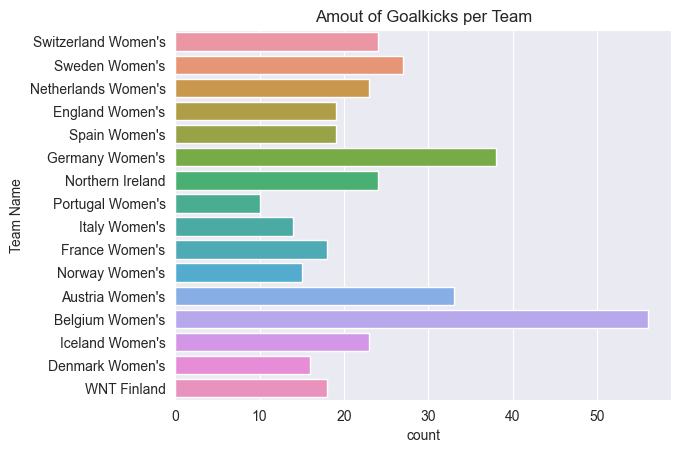

In [103]:
sns.countplot(data=goalkick, y='team_name', orient='h')
plt.ylabel('Team Name')
plt.title('Amout of Goalkicks per Team')

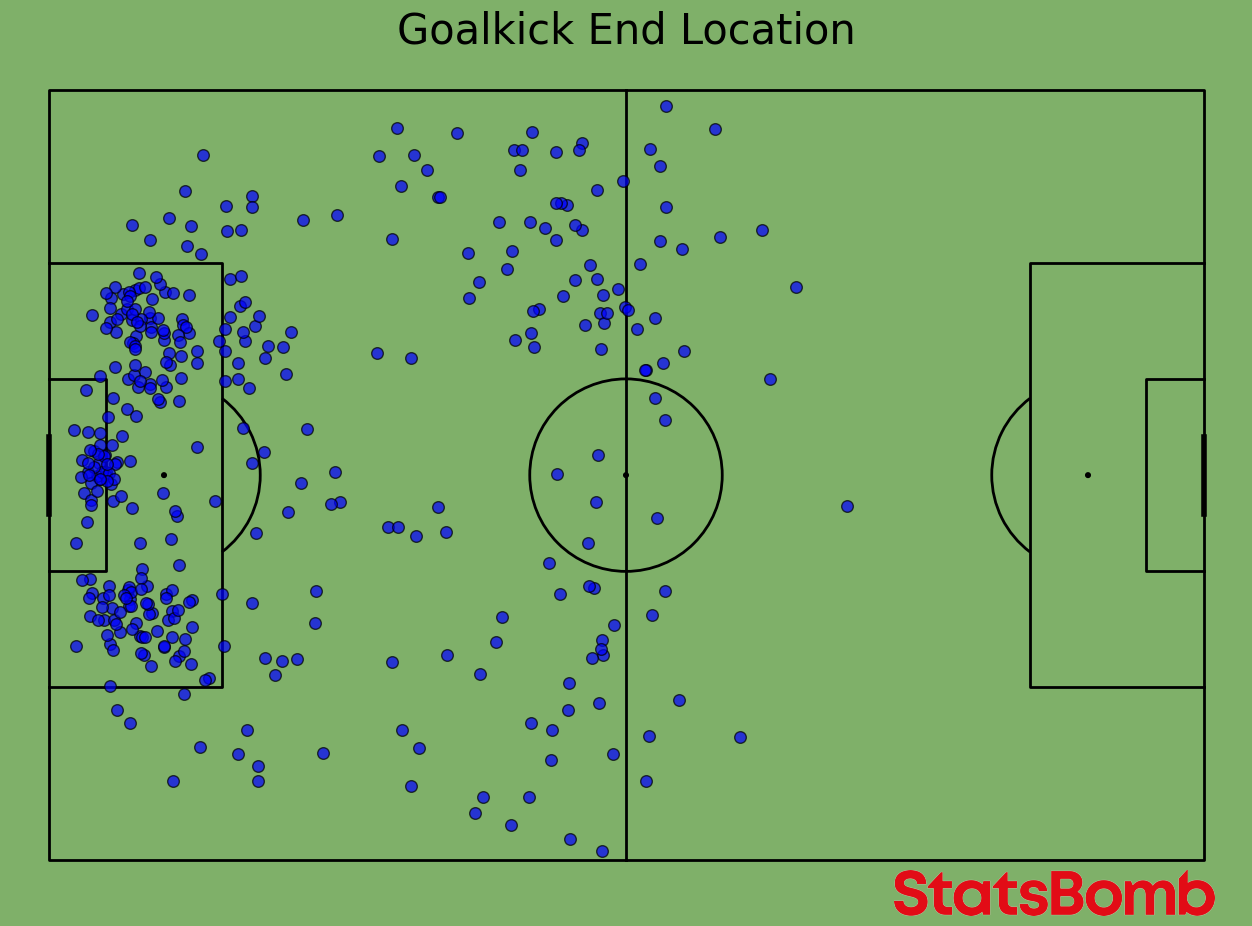

In [11]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, line_color= linesColor, pitch_color= pitchColor)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

# bg color
fig.set_facecolor(pitchColor)

# scatter
pitch.scatter(x=goalkick['end_x'], y=goalkick['end_y'],
             color= "blue", edgecolor='black',ax=ax, alpha = .70, marker='o', s=70, zorder=2)
# title
plt.title('Goalkick End Location', fontsize=30)

# statsbomb logo
ax3 = fig.add_axes([0.68, 0.09, 0.20, 0.05])
ax3.axis('off')
ax3.imshow(im)

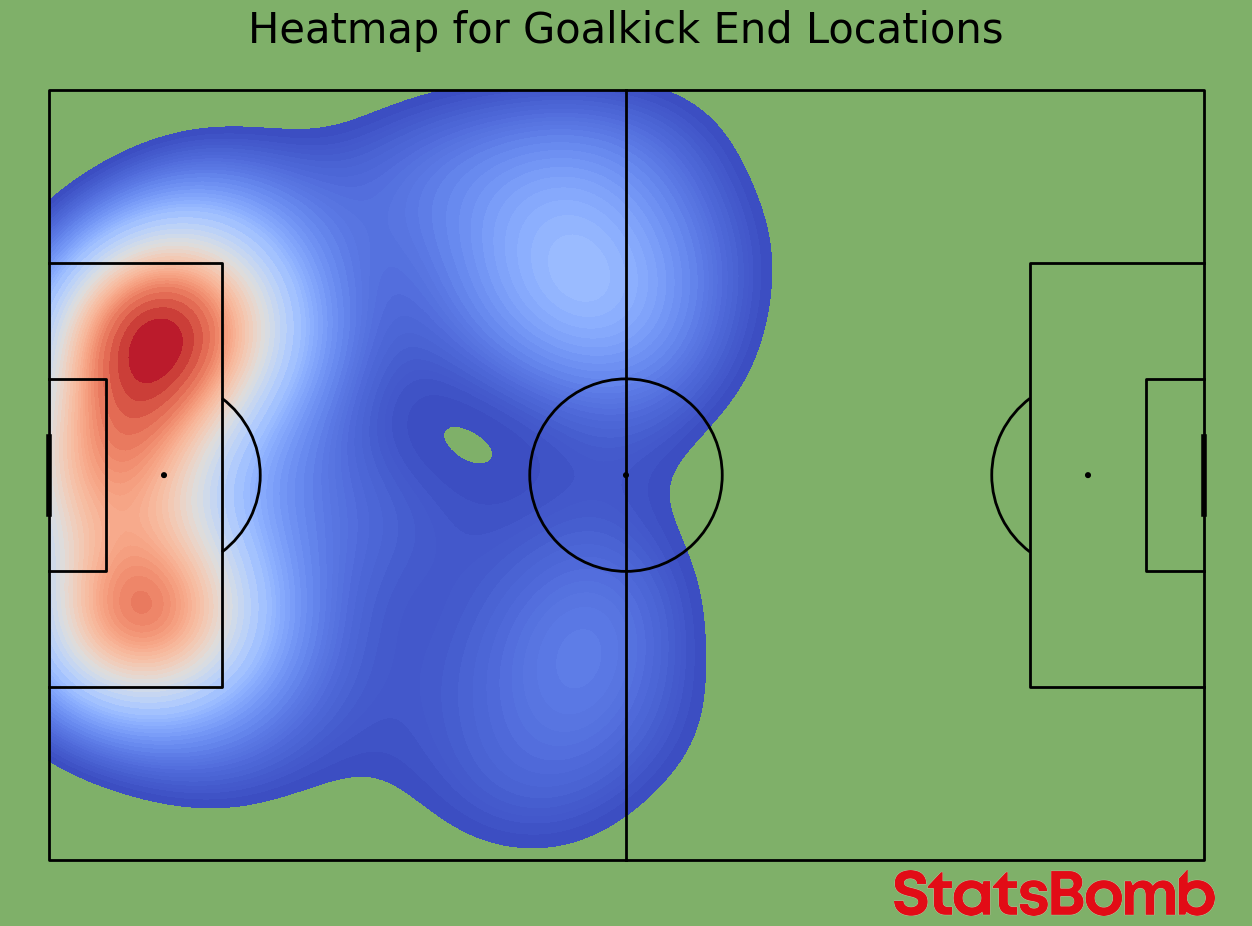

In [126]:
pitch = Pitch(pitch_type='statsbomb',  line_zorder=2, line_color=linesColor, pitch_color=pitchColor)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
# bg color
fig.set_facecolor(pitchColor)

# heatmap
kde = pitch.kdeplot(goalkick.end_x, goalkick.end_y, ax=ax,
                    fill=True, levels=50,
                    shade_lowest=False,
                    cmap='coolwarm')

# title
ax.set_title('Heatmap for Goalkick End Locations', fontsize=30, color='black')


# statsbomb logo
ax3 = fig.add_axes([0.68, 0.09, 0.20, 0.05])
ax3.axis('off')
ax3.imshow(im)

**Machine Learning**

In [42]:
X = np.array(goalkick[['end_x','end_y']])

# Get the optimal number of clusters
def optimise_k_means(data, max_k):
    means= []
    inertias = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)

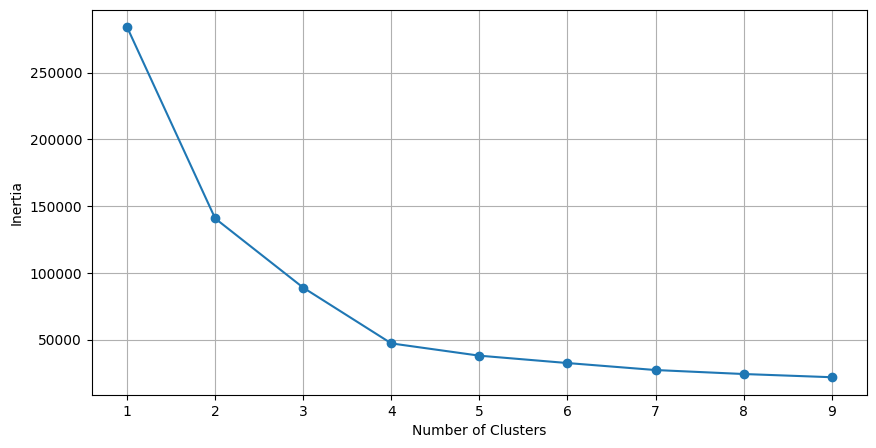

In [43]:
optimise_k_means(X, 10)

In [44]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
goalkick['cluster'] = kmeans.predict(X)

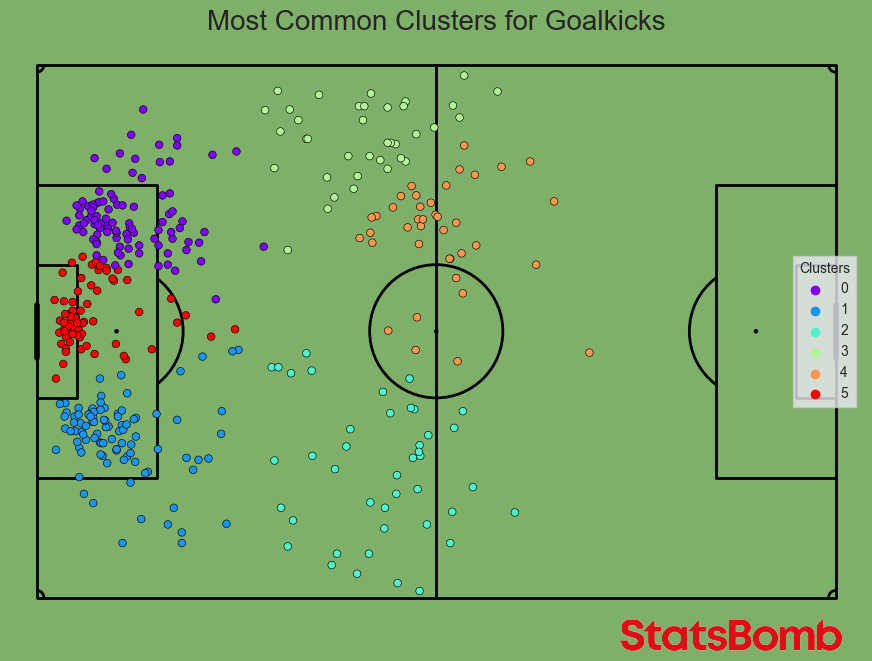

In [96]:
pitch = Pitch(pitch_type='statsbomb',  line_zorder=1, line_color=linesColor, pitch_color=pitchColor, corner_arcs=True)
fig, ax = pitch.draw(figsize=(11, 8), constrained_layout=True, tight_layout=False)
fig.set_facecolor(pitchColor)
sns.scatterplot(data=goalkick, x='end_x', y='end_y', hue='cluster', palette='rainbow', edgecolor='black', s=30)


plt.legend(title='Clusters', loc='center right', fancybox=False)


plt.title('Most Common Clusters for Goalkicks', size=20)


# statsbomb logo
ax3 = fig.add_axes([0.68, 0.09, 0.20, 0.05])
ax3.axis('off')
ax3.imshow(im)

Text(0, 0.5, 'Goalkick Count')

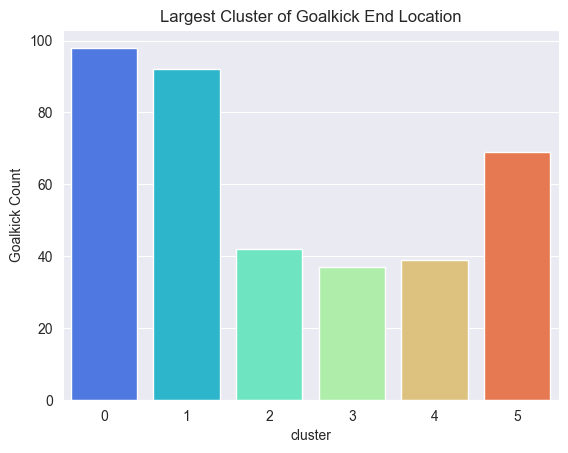

In [101]:
sns.countplot(data=goalkick, x='cluster', palette='rainbow')
plt.title('Largest Cluster of Goalkick End Location')
plt.ylabel('Goalkick Count')

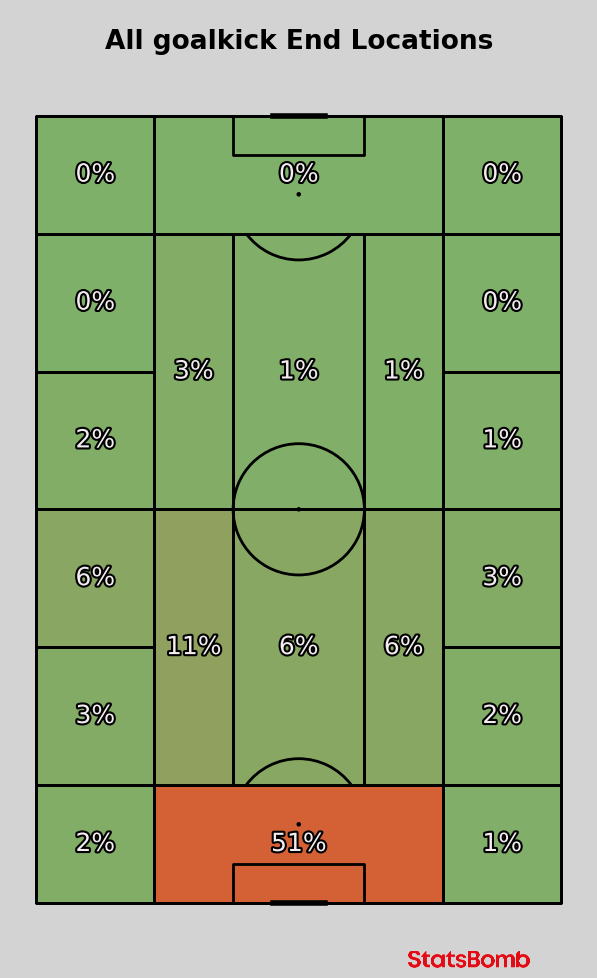

In [193]:
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color="lightgrey", line_color=linesColor)
fig, axs = pitch.grid(figheight=10, endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      axis=False,
                      grid_height=0.84)
# figure bg color
fig.set_facecolor("lightgrey")


# Pitch Sections
bin_statistic = pitch.bin_statistic_positional(goalkick.end_x, goalkick.end_y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pitchCmap, edgecolors=linesColor)

axs["title"].text (0.5, 0.6, (f"All goalkick End Locations"), 
                   color="black",va="center", ha="center", fontsize=19, fontweight="bold")

# Text in Pitch sections
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# statsbomb logo
ax3 = fig.add_axes([0.68, 0.00, 0.20, 0.05])
ax3.axis('off')
ax3.imshow(im)

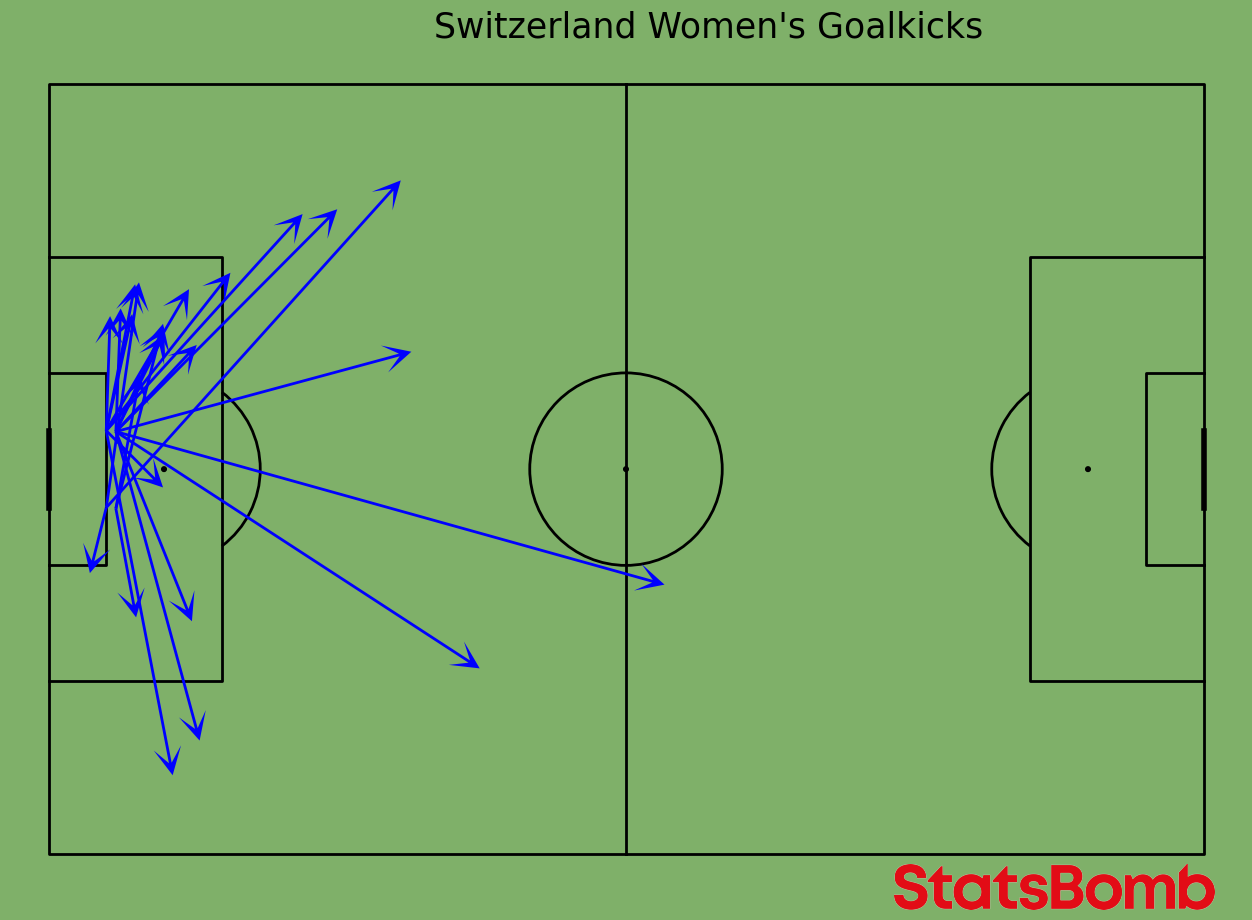

In [127]:
def Goalkick(team, color = '#444444', save=False):

    tempdf = goalkick[goalkick['team_name'] == team]
    
    pitch = Pitch(pitch_type='statsbomb', line_zorder=1, line_color= linesColor, pitch_color= pitchColor)
    fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
    fig.set_facecolor(pitchColor)

    pitch.arrows(tempdf['x'], tempdf['y'],
    tempdf['end_x'], tempdf['end_y'], ax=ax, color="blue", width=2,
             headwidth=10, headlength=10)

    ax.text(40, -5, f"{team} Goalkicks", fontsize=25)
    
    # statsbomb logo
    ax3 = fig.add_axes([0.68, 0.09, 0.20, 0.05])
    ax3.axis('off')
    ax3.imshow(im)

    if save == True:
        plt.savefig(f"{team} Viz/goalkick.png")
        plt.close(fig)
    else:    
        plt.show()

Goalkick("Switzerland Women's")

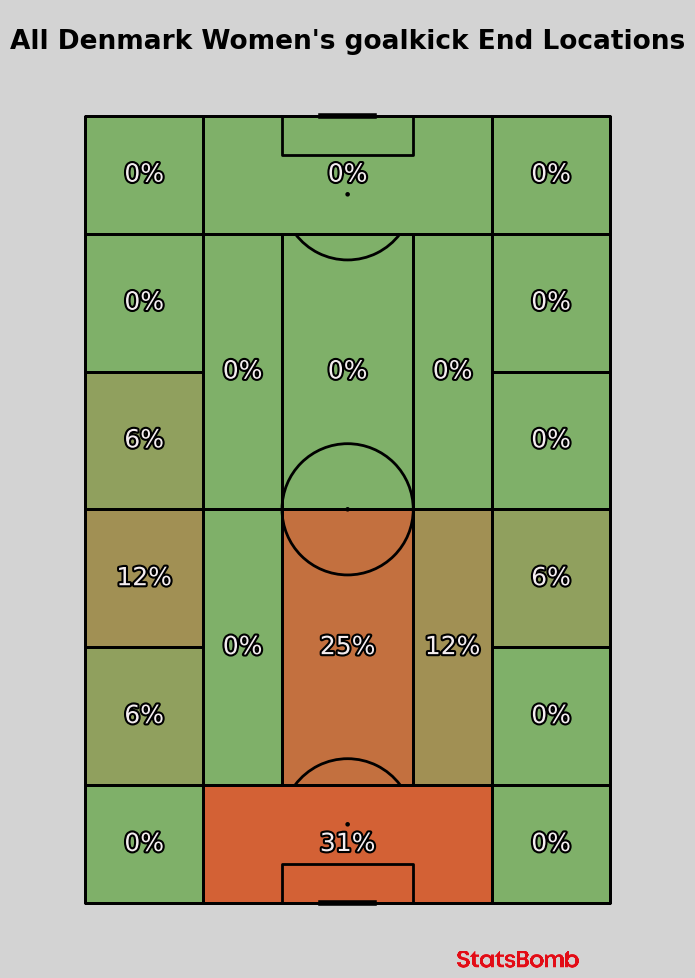

In [192]:
def Goalkick(team, color = '#444444', save=False):

    tempdf = goalkick[goalkick['team_name'] == team]
    
    pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color="lightgrey", line_color=linesColor)
    fig, axs = pitch.grid(figheight=10, endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      axis=False,
                      grid_height=0.84)
    fig.set_facecolor("lightgrey")

    bin_statistic = pitch.bin_statistic_positional(tempdf.end_x, tempdf.end_y, statistic='count',
                                               positional='full', normalize=True)
    pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pitchCmap, edgecolors=linesColor)
    labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

    axs["title"].text (0.5, 0.6, (f"All {team} goalkick End Locations"), color="black", 
                   va="center", ha="center", fontsize=19, fontweight="bold")
    
    # statsbomb logo
    ax3 = fig.add_axes([0.68, 0.00, 0.20, 0.05])
    ax3.axis('off')
    ax3.imshow(im)

    
    if save == True:
        plt.savefig(f"Viz/{team}s goalkicks during {tournament}")
        plt.close(fig)
    else:    
        plt.show()

Goalkick("Denmark Women's")

<Figure size 1200x800 with 0 Axes>

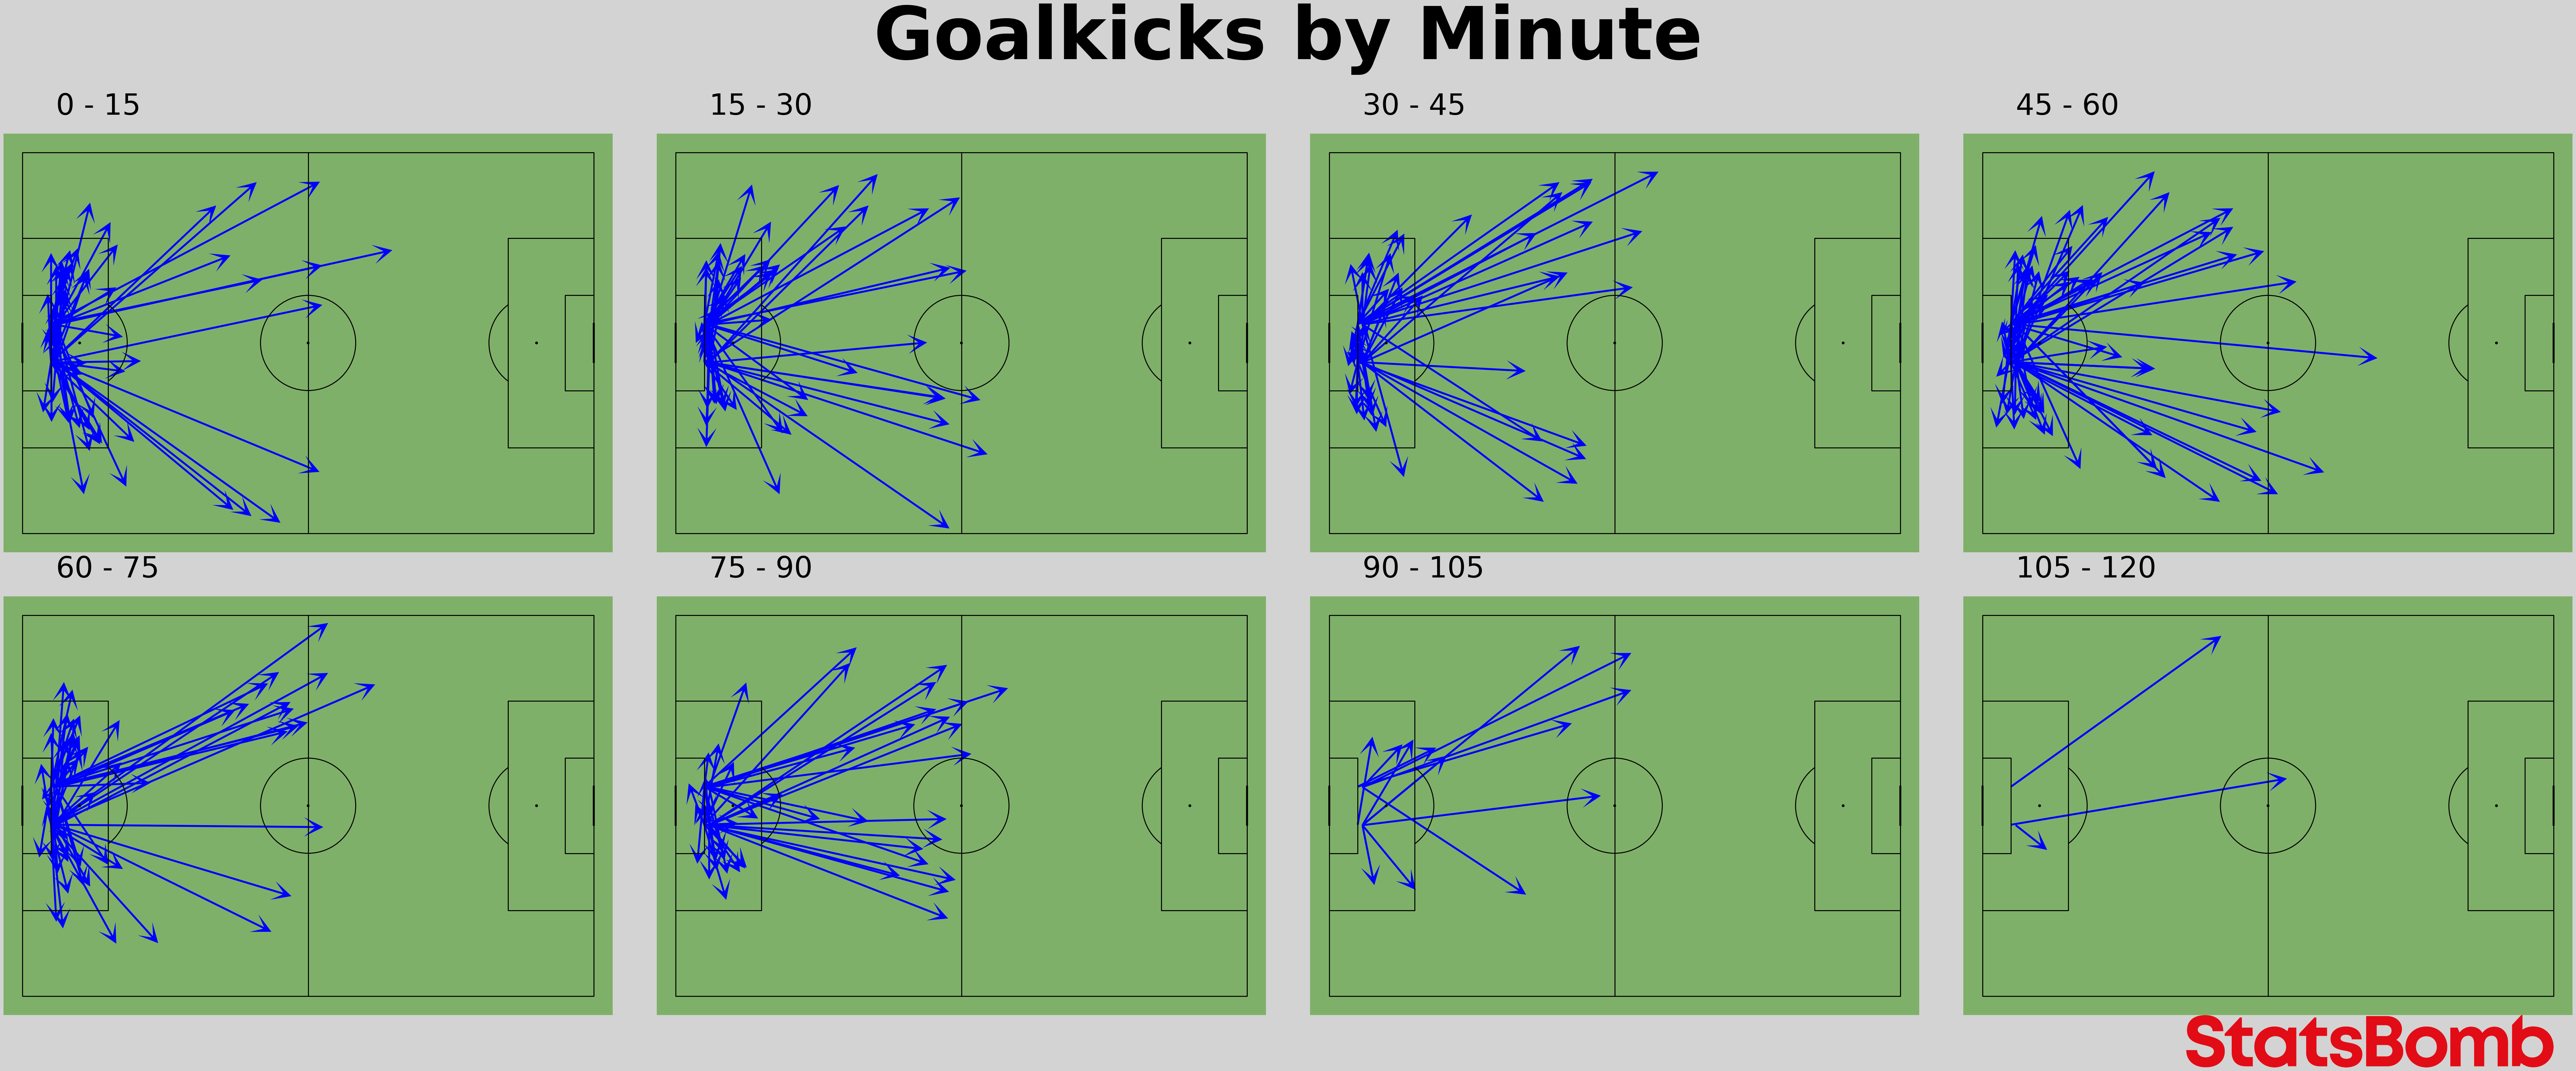

In [199]:
plt.figure(figsize=(12,8))
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color=pitchColor, line_color=linesColor)
fig, axs = pitch.grid(nrows=2, ncols=4, figheight=30,
                      endnote_height=0.03, endnote_space=0,
                      axis=False,
                      title_height=0.08, grid_height=0.84)
fig.set_facecolor("lightgrey")

# loops through minutes
for i, ax in enumerate(axs["pitch"].flat):
    tempPasses = goalkick[(goalkick["minute"]>i*15) & (goalkick["minute"]<i*15+15)]
    
    ax.text(7, -8, f"{i*15} - {i*15+15}", fontsize=60)
    
    pitch.arrows(tempPasses['x'], tempPasses["y"],tempPasses["end_x"], tempPasses["end_y"],
                 ax=ax, width=4, headwidth=10, headlength=10, color="blue")


# title
axs['title'].text(0.5,1,"Goalkicks by Minute", fontsize=150, fontweight='bold',ha='center', va='center')

# statsbomb logo
ax3 = fig.add_axes([0.80, 0, 0.20, 0.05])
ax3.axis('off')
ax3.imshow(im)



# Save fig
# plt.savefig(f'viz/Goalkicks by Minute', dpi=100, bbox_inches='tight')